In [1]:
import math
import random
import torch
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.nn as nn
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt


C:\Users\tomgr\anaconda3\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\tomgr\anaconda3\lib\site-packages\torchaudio\backend\utils.py:89: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [2]:
torch.cuda.is_available()

True

In [3]:
import socketserver
import socket
import struct
import json

import numpy as np


class IPCError(Exception):
    pass

class UnknownMessageClass(IPCError):
    pass

class InvalidSerialization(IPCError):
    pass

class ConnectionClosed(IPCError):
    pass


def _read_objects(sock):
    header = sock.recv(4)
    if len(header) == 0:
        raise ConnectionClosed()
    size = struct.unpack('!i', header)[0]
    data = sock.recv(size - 4)
    if len(data) == 0:
        raise ConnectionClosed()
    return Message.deserialize(json.loads(data))


def _write_objects(sock, objects):
    data = json.dumps([o.serialize() for o in objects])
    sock.sendall(struct.pack('!i', len(data) + 4))
    sock.sendall(data)

def _recursive_subclasses(cls):
    classmap = {}
    for subcls in cls.__subclasses__():
        classmap[subcls.__name__] = subcls
        classmap.update(_recursive_subclasses(subcls))
    return classmap


class Message(object):
    @classmethod
    def deserialize(cls, objects):
        classmap = _recursive_subclasses(cls)
        serialized = []
        for obj in objects:
            if isinstance(obj, Message):
                serialized.append(obj)
            else:
                try:
                    serialized.append(classmap[obj['class']](*obj['args'], **obj['kwargs']))
                except KeyError as e:
                    raise UnknownMessageClass(e)
                except TypeError as e:
                    raise InvalidSerialization(e)
        return serialized

    def serialize(self):
        args, kwargs = self._get_args()
        return {'class': type(self).__name__, 'args': args, 'kwargs': kwargs}

    def _get_args(self):
        return [], {}

    def __repr__(self):
        r = self.serialize()
        args = ', '.join([repr(arg) for arg in r['args']])
        kwargs = ''.join([', {}={}'.format(k, repr(v)) for k, v in r['kwargs'].items()])
        name = r['class']
        return '{}({}{})'.format(name, args, kwargs)


class Client(object):
    def __init__(self, server_address):
        self.addr = server_address
        if isinstance(self.addr, str):
            address_family = socket.AF_UNIX
        else:
            address_family = socket.AF_INET
        self.sock = socket.socket(address_family, socket.SOCK_STREAM)

    def connect(self):
        self.sock.connect(self.addr)

    def close(self):
        self.sock.close()

    def __enter__(self):
        self.connect()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.close()

    def send(self, objects):
        _write_objects(self.sock, objects)
        return _read_objects(self.sock)

    def recv(self, data):
        print("ooh got data")


class Server(socketserver.ThreadingTCPServer):
    def __init__(self, server_address, callback, bind_and_activate=True):
        if not callable(callback):
            callback = lambda x: []

        class IPCHandler(socketserver.BaseRequestHandler):
            def handle(self):
                while True:
                    try:
                        results = _read_objects(self.request)
                    except ConnectionClosed as e:
                        return
                    _write_objects(self.request, callback(results))

        if isinstance(server_address, str):
            self.address_family = socket.AF_UNIX
        else:
            self.address_family = socket.AF_INET

        socketserver.TCPServer.__init__(self, server_address, IPCHandler, bind_and_activate)

In [4]:
class Event(Message):
    def __init__(self, event_type, **properties):
        self.type = event_type
        self.properties = properties

    def _get_args(self):
        return [self.type], self.properties


class Response(Message):
    def __init__(self, text):
        self.text = text

    def _get_args(self):
        return [self.text], {}


def server_process_request(objects):
    response = [Response('Received {} objects'.format(len(objects)))]
    print('Received objects: {}'.format(objects))
    print('Sent objects: {}'.format(response))
    return response

server_address = ('localhost', 11586)

c = Client(server_address)

In [5]:
def get_samples(note):
    volume = 0.5     # range [0.0, 1.0]
    fs = 44100       # sampling rate, Hz, must be integer
    duration = 0.03#1.0   # in seconds, may be float
    f = note        # sine frequency, Hz, may be float

    # generate samples, note conversion to float32 array
    samples = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)
    #samples = samples + 1
    
    return samples

In [440]:
class Net (torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.embed_sz = 1
        self.proj_sz = 8
        self.lstm_h = 1
        self.filter_size = 5
        self.intra_size = 1
        
        self.norm = nn.LayerNorm((480, self.intra_size)).cuda()
        
        
        self.l0 = torch.nn.Linear(1, self.embed_sz, bias=False).cuda()
        
        self.attn = torch.nn.MultiheadAttention(480, 1, bias=False)
        self.attn_out = nn.Linear(1, 1, bias=False).cuda()
        
        self.l3 = torch.nn.Linear(1, self.intra_size, bias=False).cuda()
        self.lstm_out = nn.Linear(2, 1, bias=False).cuda()
        self.l_tmp = nn.Linear(self.embed_sz, self.intra_size, bias=False).cuda()
        
        self.kernel = torch.nn.Parameter(torch.rand((self.intra_size, self.intra_size, self.filter_size), device='cuda') - 0.5, requires_grad=True)
        
    def forward(self, x):
        bs = x.size(0)
        x = self.l0(x)
        x = x.view(bs, 1, 480)
        
        q, k, v = x, x, x
        
        x, _ = self.attn(q, k, v)
        
        x = x.view(bs, -1, 1)
        
        
        
        x = self.attn_out(x)
        x = torch.tanh(x) #<---try softmax here (I did, it was worse)
        #x = torch.add(x, v) #<- makes it worse
        #x = self.norm(x)
        
        x = self.l3(x)
        
        padded = F.pad(x.permute(0, 2, 1), ((self.filter_size//2), (self.filter_size//2)), mode='replicate')
        x = F.conv1d(padded, self.kernel)
        x = x.permute(0, 2, 1)
        
        return x


In [807]:
class Typhon:
    def __init__(self, callback, host='localhost', port=11586):
        """
        480 is 10ms @ 48kHz
        """
        self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.sock.connect((host, port))
        self.recvd = self.sock.recv(8 + len(b'EHLO') + 5 + len(b'BYE'))
        assert self.recvd[8:12] == b'EHLO', "Did not get expected response on attempted connect"
        self.bpm = float(self.recvd[12:17])
        self.recvd = b''
        self.n_samples_per_block = 0
        self.bufsize = 0 # how much data received per block #should be 1920
        self.recvsize = 8 # 8 + (self.n_samples_per_block * channels * bytes-per-data) #should be 1928
        self.callback = callback(self.bpm)
        self.msgid = None
        self.msglen = None
        self.last_data = None
        self.first_data_packet = True
    def go(self):
        while True:
            self.recvd += self.sock.recv(self.recvsize)
            if not self.recvd:
                return 0 # broke due to connection disrupted
            # TODO refactor this into 2 functions, 1 for first packet, then it switches to different func for subsequent.
            # so we don't need to always check for bufsize and first_data_packet.
            if not self.bufsize:
                self.msgid = self.recvd[0:4]
                self.msglen = self.recvd[4:8]
                self.bufsize = int.from_bytes(self.msglen, 'little')
                # At first packet, we've already received 8 bytes, so we want 1920 here not 1928
                self.recvsize = self.bufsize
                self.n_samples_per_block = self.bufsize // 2 // 2;
                continue
            if self.first_data_packet:
                # Now we need to add 8
                self.first_data_packet = False
                self.recvsize += 8
            data = np.frombuffer(self.recvd[8:-300], dtype=np.int16)
            midi_data = np.frombuffer(self.recvd[-300:], dtype=np.uint8)
            #p = mido.Parser()
            #p.feed(midi_data)
            #midi_messages = p.messages
            data = (data / 32768).reshape(2, -1).astype(np.float32)
            reply, midi_reply = self.callback(data, midi_data)#midi_messages)
            reply = reply.reshape(-1)
            reply = np.clip(reply, -1, 1)
            msg2 = (reply * 32768.0).astype(np.int16).tobytes()
            #msg2 = np.zeros_like(reply).astype(np.int16).tobytes()
            msg2 += midi_reply.astype(np.uint8).tobytes()
            #print(msg2)
            msg = self.msgid + self.msglen + msg2
            if len(msg) == self.recvsize:
                self.sock.send(msg)
            self.recvd = b''
    @classmethod
    def Butterworth_Filter(cls, low=3, high=5, samples=480, order=3):
        from scipy.signal import butter, lfilter, sosfilt
        def butter_bandpass(lowcut, highcut, fs, order=3):
            filt = butter(order, [low, high], btype='band', output="sos", fs=fs)
            return filt
        class Filter:
            def __init__(self, low, high, samples, order):
                #self.filt = butter_bandpass(low, high, samples, order)
                self.filt = iirfilter(10, 300, btype='lowpass', analog=False, ftype='bessel', output="sos", fs=samples)
            def __call__(self, data):
                f = sosfilt(self.filt, data)
                return f
        return Filter(low, high, samples, order)

In [825]:
class MyCallback:
    def __init__(self, bpm=120.0):
        self.bpm = bpm
        self.net = Net()
        self.net.load_state_dict(torch.load("quant_net_960_mono.bin"))
        self.net.cuda()
        self.net.eval()
        self.last_in = None
        self.last_out = None
    def __call__(self, audio_data, midi_data):
        audio_data = torch.tensor(audio_data, dtype=torch.float32, requires_grad=False, device='cuda')
        audio_data = audio_data.view(2, -1, 1)
        midi_reply = np.zeros_like(midi_data)
        for i in range(len(midi_data)):
            midi_reply[i] = midi_data[i]
            if 70 < midi_data[i] < 80:
                midi_reply[i] = 60
#         if midi_data.sum() > 0:
#             print(midi_data, midi_reply)
        with torch.no_grad():
            reply = self.net(audio_data)
        reply = reply.view(2, -1)
        torch.clamp_(reply, -1, 1)
        reply = reply.cpu().numpy()
        if audio_data.sum() > 0.8:
            self.last_in = audio_data
            self.last_out = reply
        return reply, midi_reply

In [891]:
t = Typhon(MyCallback)

In [892]:
t.go()

0

In [454]:
t.midi_data

array([  0,   0,   0,   0,   3,   0, 128,  76,   0,   0,   0,   0,   0,
         3,   0, 144,  77,  87, 184,   1,   0,   0,   3,   0, 128,  77,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [484]:
p = mido.Parser()

In [489]:
p.feed(t.midi_data)

In [490]:
p.messages

deque([Message('note_off', channel=0, note=76, velocity=0, time=0),
       Message('note_on', channel=0, note=77, velocity=87, time=0),
       Message('control_change', channel=8, control=1, value=0, time=0),
       Message('note_off', channel=0, note=77, velocity=0, time=0),
       Message('note_off', channel=0, note=76, velocity=0, time=0),
       Message('note_on', channel=0, note=77, velocity=87, time=0),
       Message('control_change', channel=8, control=1, value=0, time=0),
       Message('note_off', channel=0, note=77, velocity=0, time=0)])

In [456]:
import mido

In [487]:
p.feed

<bound method Parser.feed of <mido.parser.Parser object at 0x00000263EFA2C0A0>>

In [473]:
qwe

b'\x00\x00\x00\x00\x03\x00\x80L\x00\x00\x00\x00\x00\x03\x00\x90MW\xb8\x01\x00\x00\x03\x00\x80M\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

In [474]:
mido.parse([144, 77, 87])

Message('note_on', channel=0, note=77, velocity=87, time=0)

In [483]:
list(t.midi_data)

[0,
 0,
 0,
 0,
 3,
 0,
 128,
 76,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 144,
 77,
 87,
 184,
 1,
 0,
 0,
 3,
 0,
 128,
 77,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [482]:
mido.parse(list(t.midi_data))

Message('note_off', channel=0, note=76, velocity=0, time=0)

<IPython.core.display.Javascript object>


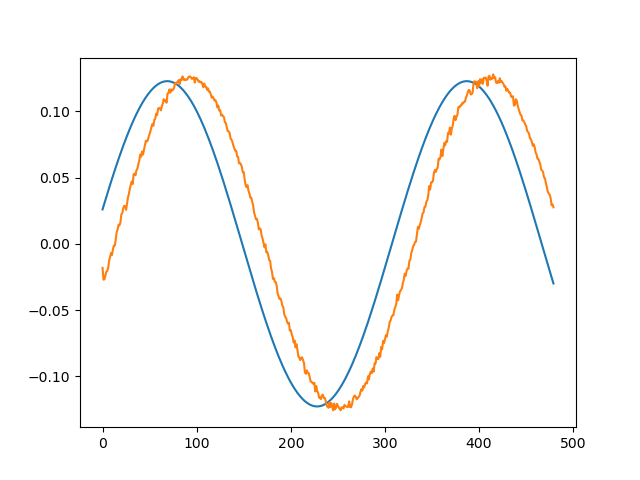

In [439]:
plt.clf()
plt.plot(t.callback.last_in[0].cpu().numpy())
plt.plot(t.callback.last_out[0])
#plt.plot(t.callback.last_in[0].cpu().numpy()[::-1])

In [192]:
x = t.callback.last_out

In [193]:
x.shape

(2, 480)

In [197]:
x

array([[-0.8766144 , -0.866334  , -0.86245716, -0.8316053 , -0.9243772 ,
        -0.936358  , -0.919555  , -0.9119355 , -0.92805594, -0.9245408 ,
        -0.9162432 , -0.90110195, -0.85615444, -0.85029405, -0.8591271 ,
        -0.8696043 , -0.7315968 , -0.7249604 , -0.73432136, -0.7261898 ,
        -0.5504971 , -0.5481288 , -0.565419  , -0.57177085, -0.35014188,
        -0.3546543 , -0.36526138, -0.363853  , -0.12790447, -0.12853882,
        -0.14094403, -0.15137854,  0.10805021,  0.10157011,  0.09193717,
         0.08591165,  0.3294689 ,  0.32549495,  0.31294525,  0.30446917,
         0.5256407 ,  0.51781666,  0.51273155,  0.50302327,  0.69116277,
         0.6895461 ,  0.68240285,  0.6771322 ,  0.81595284,  0.8119616 ,
         0.81033665,  0.798222  ,  0.88527644,  0.8830594 ,  0.8842739 ,
         0.87636447,  0.8948227 ,  0.8933594 ,  0.9002465 ,  0.8924961 ,
         0.8600482 ,  0.85469043,  0.86353934,  0.85719705,  0.757758  ,
         0.7575452 ,  0.7663052 ,  0.7644842 ,  0.6

In [23]:
plt.clf()
plt.plot(t.callback.last_in[1, :100].cpu().numpy())
plt.plot(t.callback.last_out[1, :100])
#plt.plot(t.callback.last_in[0].cpu().numpy()[::-1])

In [12]:
t.callback.last_out.max()

0.13877027

In [11]:
t.callback.last_in.max()

tensor(0.1625, device='cuda:0')

In [13]:
t.callback.last_in

tensor([[[ 6.0150e-02],
         [ 6.8878e-02],
         [ 7.7301e-02],
         [ 8.5419e-02],
         [ 9.3201e-02],
         [ 1.0065e-01],
         [ 1.0770e-01],
         [ 1.1438e-01],
         [ 1.2067e-01],
         [ 1.2656e-01],
         [ 1.3202e-01],
         [ 1.3705e-01],
         [ 1.4166e-01],
         [ 1.4581e-01],
         [ 1.4951e-01],
         [ 1.5277e-01],
         [ 1.5555e-01],
         [ 1.5787e-01],
         [ 1.5970e-01],
         [ 1.6110e-01],
         [ 1.6202e-01],
         [ 1.6248e-01],
         [ 1.6248e-01],
         [ 1.6205e-01],
         [ 1.6113e-01],
         [ 1.5982e-01],
         [ 1.5805e-01],
         [ 1.5585e-01],
         [ 1.5326e-01],
         [ 1.5024e-01],
         [ 1.4685e-01],
         [ 1.4310e-01],
         [ 1.3895e-01],
         [ 1.3449e-01],
         [ 1.2967e-01],
         [ 1.2457e-01],
         [ 1.1914e-01],
         [ 1.1346e-01],
         [ 1.0751e-01],
         [ 1.0129e-01],
         [ 9.4879e-02],
         [ 8.825